# Predicting Ratings using Spacy and Glove

## Importing required libraries

In [140]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import re
# Get the interactive Tools for Matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import nltk
nltk.download('stopwords')
# nltk.corpus import stopwords

## loading Spacy model

In [141]:

import spacy
nlp = spacy.load('en_core_web_md')  # Use 'en_core_web_md' 


### Sample code to calculate similarity using Spacy

In [9]:
text1 = " cat"
text2 = "car"

# Process the texts with the nlp model
doc1 = nlp(text1)
doc2 = nlp(text2)

# Calculate similarity between the two texts
similarity = doc1.similarity(doc2)

In [10]:
similarity

0.19698592764608053

### Loading and printing different Data sets using pandas

In [11]:
train_df = pd.read_csv(r"C:\Users\pruth\Downloads\project\interactions_train.csv")

test_df = pd.read_csv(r"C:\Users\pruth\Downloads\project\interactions_test.csv")

validation_df = pd.read_csv(r"C:\Users\pruth\Downloads\project\interactions_validation.csv")

recipie = pd.read_csv(r"C:\Users\pruth\Downloads\project\RAW_recipes.csv")

user = pd.read_csv(r"C:\Users\pruth\Downloads\project\RAW_interactions.csv")

In [14]:
train_df

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723
...,...,...,...,...,...,...
698896,926904,457971,2018-12-18,5.0,13681,141067
698897,2002312797,27208,2018-12-18,5.0,14897,99787
698898,1290903,131607,2018-12-18,5.0,11605,76163
698899,226867,363072,2018-12-18,5.0,3604,29101


In [15]:
recipie

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10


## We are using data flow below

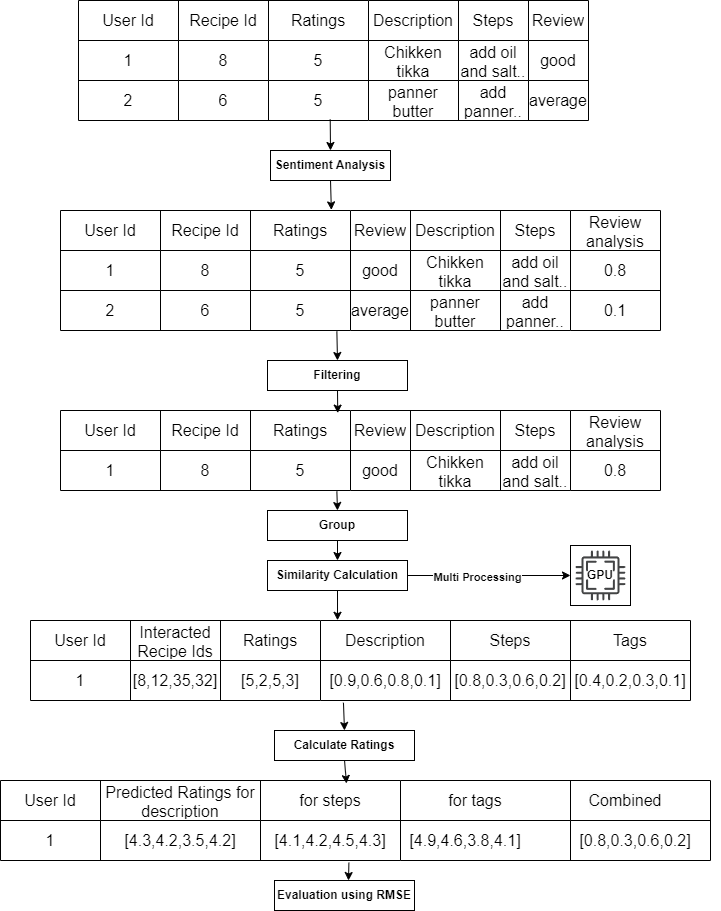

In [16]:
# columns containing all the textual columns which are considered to calculate item item similarity
cols = ["steps","description","ingredients","tags"]

In [17]:
# creating a dictionary with keys as user id and values as another dictionary of textual columns and values of recipies rated by respective user
unique_ui = list(set(list(train_df["user_id"])))
dic = {}

In [18]:
# for all users fill the dictionary for all reviewed recipes
for ui in tqdm(unique_ui):
    dic[ui]={"steps" : [],
    "description" : [],
    "ingredients" : []
    ,"tags" : []
    ,"rating":[]        }
    temp = train_df[train_df["user_id"]== ui]

    for bi in list(temp["recipe_id"]):
        btemp = recipie[recipie["id"] == bi]
        for c in cols:
            dic[ui][c].append(btemp[c])
        dic[uix]["rating"].append(temp[temp["recipe_id"] == bi]["rating"].values[0])
    

100%|████████████████████████████████████████████████████████████████████████████| 25076/25076 [21:02<00:00, 19.86it/s]


In [19]:
import pickle 

      
# Save the dictionary as a pickle object in order to avoid calculating every time the code is ran
with open("user_recipe.pickle", "wb") as outfile:
    pickle.dump(dic, outfile)

In [20]:
# method to calculate similarity between two texts using spacy model
def get_similarity(s1,s2):
    try:
        s1_encoded = nlp(s1)
        s2_encoded = nlp(s2)

        return s1_encoded.similarity(s2_encoded)
    except Exception as e:
        #print(e)
        return 0
    
# method to calculate similarity for each textual column of recipes rated by user against a specific input recipe_id
def predict_sim_measure(userid,recipeid):
    user_dict = dic[userid]
    recipie_info = recipie[recipie["id"]==recipeid]
    ratings = {}
    for c in cols:
        ratings[c] = []
        for i in range(len(user_dict[c])):
            if(len(user_dict[c][i]) !=0):
                ratings[c].append(get_similarity(list(user_dict[c][i])[0],list(recipie_info[c])[0]))
    
    return ratings,user_dict["rating"]

In [21]:
predict_sim_measure(1290903,27208)

({'steps': [0.9359336636354729,
   0.9527289513057441,
   0.9516893535748667,
   0.9539200222113045,
   0.9569035650290058,
   0.9527363285404545,
   0.8308475179130173,
   0.8853570546167336,
   0.947038359211942,
   0.9171217991784804,
   0.9604507436711474,
   0.9074509435506358,
   0.8771020757773574,
   0.9499714515961231,
   0.8538089385918067,
   0.9344162367700799,
   0.9219484337318954,
   0.9468377919199761,
   0.9531158257666827,
   0.9445210247999165,
   0.9417219312336287,
   0.8463261942206252],
  'description': [0,
   0.8870990748641281,
   0.8885811697747285,
   0.9362943512871265,
   0.7800541813637543,
   0.8293534050499705,
   0.9443832378163359,
   0.8161481007356634,
   0.8904502421607631,
   0.9167557668961068,
   0.8585701863759544,
   0.9050258104948014,
   0.9097472880573827,
   0.8907288696791976,
   0.9273627877626371,
   0.9000874519376642,
   0.780663485456672,
   0.91179624982676,
   0.9291297278889631,
   0.8801379181204892,
   0.9176123479573715,
   0.69

In [22]:
# method to calculate rating using the formula from below image
def predict_user_item_rating(userid,recipeid):
    sim_measure, ratings = predict_sim_measure(userid,recipeid)
    avg_rating = []
    for c in cols:
        avg_rating.append(np.dot(sim_measure[c],ratings)/sum(sim_measure[c]))
    return avg_rating

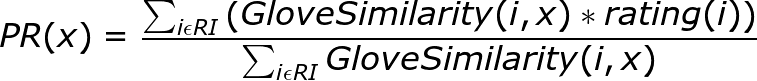

In [23]:
predict_user_item_rating(1290903,27208)

[4.768327323093083, 4.852024582447257, 4.772680323580814, 4.771647951366474]

In [24]:
# creating a list to store predicted ratings for each user item pair using above methos
test_pred_ratings = []

In [25]:
# getting a list of all user ids and recipe ids
user_list = list(test_df["user_id"])
recipe_list = list(test_df["recipe_id"])


In [26]:
# for all user 
for u in tqdm(range(len(user_list))):
    test_pred_ratings.append(predict_user_item_rating(user_list[u],recipe_list[u]))

100%|███████████████████████████████████████████████████████████████████████| 12455/12455 [00:00<00:00, 2483246.49it/s]


In [78]:
# save the object as pickle file to reuse later
with open("test_pred_ratings.pickle", "wb") as outfile:
    pickle.dump(test_pred_ratings, outfile)

In [27]:
# loading the pickle file
with open('test_pred_ratings.pickle', 'rb') as f:
    test_pred_ratings = pickle.load(f)

In [28]:
# transposing the data
test_pred_ratings_np = np.array(test_pred_ratings)
test_pred_ratings_np = test_pred_ratings_np.transpose()
test_pred_ratings_np[0]

array([4.22325352, 4.83234553, 5.        , ..., 5.        , 5.        ,
       2.96792291])

In [29]:
# appending the rows into the test data frame
k=0
for c in cols:
    test_df[c+"_sim_rating"] = test_pred_ratings_np[k]
    k+=1

In [30]:
test_df

,user_id,recipe_id,date,rating,u,i,steps_sim_rating,description_sim_rating,ingredients_sim_rating,tags_sim_rating
0,8937,44551,2005-12-23,4.0,2,173538,4.223254,4.237901,4.223033,4.222482
1,56680,126118,2006-10-07,4.0,16,177847,4.832346,4.826278,4.833152,4.833118
2,349752,219596,2008-04-12,0.0,26,89896,5.000000,5.000000,5.000000,5.000000
3,628951,82783,2007-11-13,2.0,45,172637,5.000000,NaN,5.000000,5.000000
4,92816,435013,2013-07-31,3.0,52,177935,4.569543,4.583392,4.566738,4.566046
...,...,...,...,...,...,...,...,...,...,...
12450,101053,179011,2009-01-03,5.0,25054,130258,5.000000,5.000000,5.000000,5.000000
12451,252205,81398,2005-12-26,2.0,25055,152255,4.502859,4.462176,4.499925,4.497152
12452,624305,142984,2011-01-15,1.0,25057,139864,5.000000,5.000000,5.000000,5.000000
12453,173575,104842,2004-12-18,3.0,25059,140646,5.000000,5.000000,5.000000,5.000000


In [31]:
# calculating RMSE for each textual feature
for i in cols:
    print(mean_squared_error(test_df["rating"],test_df[c+"_sim_rating"]))

1.8333342137586792
1.8333342137586792
1.8333342137586792
1.8333342137586792


## Somthening and Bagging using a Linear Regression on all features 

In [57]:
# removing na values
test_df = test_df.dropna()
test_df

,user_id,recipe_id,date,rating,u,i,steps_sim_rating,description_sim_rating,ingredients_sim_rating,tags_sim_rating
0,8937,44551,2005-12-23,4.0,2,173538,4.223254,4.237901,4.223033,4.222482
1,56680,126118,2006-10-07,4.0,16,177847,4.832346,4.826278,4.833152,4.833118
2,349752,219596,2008-04-12,0.0,26,89896,5.000000,5.000000,5.000000,5.000000
4,92816,435013,2013-07-31,3.0,52,177935,4.569543,4.583392,4.566738,4.566046
5,280271,228179,2007-07-29,5.0,55,178179,4.653425,4.654591,4.653802,4.653992
...,...,...,...,...,...,...,...,...,...,...
12450,101053,179011,2009-01-03,5.0,25054,130258,5.000000,5.000000,5.000000,5.000000
12451,252205,81398,2005-12-26,2.0,25055,152255,4.502859,4.462176,4.499925,4.497152
12452,624305,142984,2011-01-15,1.0,25057,139864,5.000000,5.000000,5.000000,5.000000
12453,173575,104842,2004-12-18,3.0,25059,140646,5.000000,5.000000,5.000000,5.000000


In [90]:
# split using train test spit with 20 % test data
X_train, X_test, y_train, y_test = train_test_split(
...     test_df[["steps_sim_rating","description_sim_rating","ingredients_sim_rating","tags_sim_rating"]], test_df["rating"], test_size=0.20, random_state=42)

In [91]:
# creating a linear regression model
model = LinearRegression()

In [92]:
# training the model on train set
model.fit(X_train, y_train)

LinearRegression()

In [93]:
# predicting on test data using the above model
y_ans = model.predict(X_test)

In [95]:
print(mean_squared_error(y_ans,y_test))

0.79476202688544


## Using Glove model to calculate similarities

### loading a downloaded love model

In [98]:
glove_file = datapath(r"C:\Users\pruth\Downloads\glove.6B.100d.txt\glove.6B.100d.txt")
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

C:\Users\pruth\AppData\Local\Temp\ipykernel_16732\3178362099.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)


(400000, 100)

### Experimenting with glove model

In [99]:
# loading the model
model = KeyedVectors.load_word2vec_format(word2vec_glove_file)


In [100]:
#predicting most similar values for a given word
model.most_similar('obama')


[('barack', 0.9372164607048035),
 ('bush', 0.927285373210907),
 ('clinton', 0.8960004448890686),
 ('mccain', 0.8875633478164673),
 ('gore', 0.8000321388244629),
 ('hillary', 0.7933662533760071),
 ('dole', 0.7851964831352234),
 ('rodham', 0.7518897652626038),
 ('romney', 0.7488929629325867),
 ('kerry', 0.7472624182701111)]

In [121]:
# method to calculate similatity using glove for words
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [124]:
# method to draw a scatter plot for vectors created of words using glove
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='b', c='g')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

<IPython.core.display.Javascript object>


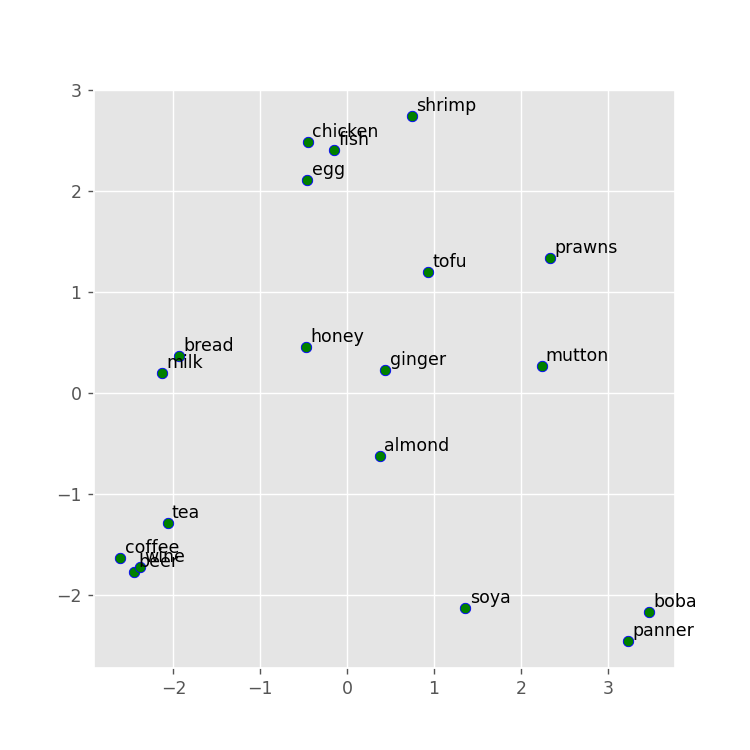

In [125]:
# plotting different words related to food using glove vectores
display_pca_scatterplot(model, 
                        ['coffee', 'tea', 'beer', 'wine', 'chicken', "mutton","shrimp","fish","prawns","panner","tofu","boba","soya",
                            "ginger","egg","milk","almond","honey","bread"], sample=300)

In [126]:
model.similarity("cat","dog")

0.87980753

### Loading and printing different Data sets using pandas

In [127]:

train_df = pd.read_csv(r"C:\Users\pruth\Downloads\project\interactions_train.csv")

test_df = pd.read_csv(r"C:\Users\pruth\Downloads\project\interactions_test.csv")

validation_df = pd.read_csv(r"C:\Users\pruth\Downloads\project\interactions_validation.csv")

recipie = pd.read_csv(r"C:\Users\pruth\Downloads\project\RAW_recipes.csv")

user = pd.read_csv(r"C:\Users\pruth\Downloads\project\RAW_interactions.csv")

In [128]:
train_df

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723
...,...,...,...,...,...,...
698896,926904,457971,2018-12-18,5.0,13681,141067
698897,2002312797,27208,2018-12-18,5.0,14897,99787
698898,1290903,131607,2018-12-18,5.0,11605,76163
698899,226867,363072,2018-12-18,5.0,3604,29101


In [129]:
recipie

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10


In [130]:
# columns containing all the textual columns which are considered to calculate item item similarity

cols = ["steps","description","ingredients","tags"]

In [131]:
# creating a dictionary with keys as user id and values as another dictionary of textual columns and values of recipies rated by respective user

unique_ui = list(set(list(train_df["user_id"])))
dic = {}

In [18]:
# for all users fill the dictionary for all reviewed recipes

for ui in tqdm(unique_ui):
    dic[ui]={"steps" : [],
    "description" : [],
    "ingredients" : []
    ,"tags" : []
    ,"rating":[]        }
    temp = train_df[train_df["user_id"]== ui]

    for bi in list(temp["recipe_id"]):
        btemp = recipie[recipie["id"] == bi]
        for c in cols:
            dic[ui][c].append(btemp[c])
        dic[uix]["rating"].append(temp[temp["recipe_id"] == bi]["rating"].values[0])
    

100%|████████████████████████████████████████████████████████████████████████████| 25076/25076 [21:02<00:00, 19.86it/s]


In [132]:
  
# with open("user_recipe.pickle", "wb") as outfile:
#     pickle.dump(dic, outfile)
# Save the dictionary as a pickle object in order to avoid calculating every time the code is ran

with open('user_recipe.pickle', 'rb') as f:
    dic = pickle.load(f)

In [155]:
# method to calculate similarity between two texts using spacy model

def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_words = list(set([w for w in words if w not in stopword_set]))

    return cleaned_words
# method to calculate similarity for each textual column of recipes rated by user against a specific input recipe_id for words

def cosine_distance_wordembedding_method(s1, s2):
    import scipy
    vector_1 = np.mean([model[word] for word in preprocess(s1)],axis=0)
    vector_2 = np.mean([model[word] for word in preprocess(s2)],axis=0)
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    return 1-cosine


In [156]:


cosine_distance_wordembedding_method("the bag is black","black cat")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pruth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0.8295405507087708

In [159]:
# method to calculate similarity for each textual column of recipes rated by user against a specific input recipe_id for words

def get_similarity(s1,s2):
    try:
    
        return cosine_distance_wordembedding_method(s1,s2)
    except Exception as e:
        #print(e)
        return 0
# method to calculate rating using the formula from below image

def predict_sim_measure(userid,recipeid):
    user_dict = dic[userid]
    recipie_info = recipie[recipie["id"]==recipeid]
    ratings = {}
    for c in cols:
        ratings[c] = []
        for i in range(len(user_dict[c])):
            if(len(user_dict[c][i]) !=0):
                ratings[c].append(get_similarity(list(user_dict[c][i])[0],list(recipie_info[c])[0]))
    
    return ratings,user_dict["rating"]

In [160]:
predict_sim_measure(1290903,27208)

({'steps': [0.9006140828132629,
   0.9462347030639648,
   0.9294623732566833,
   0.9444858431816101,
   0.9369054436683655,
   0.9488376379013062,
   0,
   0.838380753993988,
   0.9174450635910034,
   0,
   0.9252167344093323,
   0.8251024484634399,
   0.8750541806221008,
   0.9635263681411743,
   0.9624582529067993,
   0.9604707360267639,
   0.9265674352645874,
   0.9180740714073181,
   0,
   0.9447002410888672,
   0.9084876775741577,
   0],
  'description': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'ingredients': [0.8737109899520874,
   0.8384804725646973,
   0.8961674571037292,
   0.8685400485992432,
   0.8912744522094727,
   0.885658860206604,
   0.8617421388626099,
   0.8643988966941833,
   0.8295533657073975,
   0.8918207883834839,
   0.8089276552200317,
   0.7302588820457458,
   0.8461717367172241,
   0.9111588001251221,
   0.8770775198936462,
   0.8621616363525391,
   0.8811913728713989,


In [161]:
# method to calculate rating using the formula from below image

def predict_user_item_rating(userid,recipeid):
    sim_measure, ratings = predict_sim_measure(userid,recipeid)
    avg_rating = []
    for c in cols:
        avg_rating.append(np.dot(sim_measure[c],ratings)/sum(sim_measure[c]))
    return avg_rating

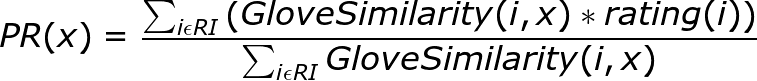

In [162]:
predict_user_item_rating(1290903,27208)

C:\Users\pruth\AppData\Local\Temp\ipykernel_16732\1132186685.py:5: RuntimeWarning: invalid value encountered in double_scalars
  avg_rating.append(np.dot(sim_measure[c],ratings)/sum(sim_measure[c]))


[4.724569659639018, nan, 4.778491624244644, 4.766464111535166]

In [163]:
# creating a list to store predicted ratings for each user item pair using above methos
test_pred_ratings = []

In [164]:
# getting a list of all user ids and recipe ids
user_list = list(test_df["user_id"])
recipe_list = list(test_df["recipe_id"])


In [165]:
# for all user 
for u in tqdm(range(len(user_list))):
    test_pred_ratings.append(predict_user_item_rating(user_list[u],recipe_list[u]))

  0%|                                                                                        | 0/12455 [00:00<?, ?it/s]C:\Users\pruth\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pruth\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\pruth\AppData\Local\Temp\ipykernel_16732\1132186685.py:5: RuntimeWarning: invalid value encountered in double_scalars
  avg_rating.append(np.dot(sim_measure[c],ratings)/sum(sim_measure[c]))
100%|████████████████████████████████████████████████████████████████████████████| 12455/12455 [11:22<00:00, 18.25it/s]


In [166]:
# save the object as pickle file to reuse later
with open("test_pred_ratings_glove.pickle", "wb") as outfile:
    pickle.dump(test_pred_ratings, outfile)

In [167]:
# loading the pickle file
with open('test_pred_ratings_glove.pickle', 'rb') as f:
    test_pred_ratings = pickle.load(f)

In [168]:
# transposing the data
test_pred_ratings_np = np.array(test_pred_ratings)
test_pred_ratings_np = test_pred_ratings_np.transpose()
test_pred_ratings_np[0]

array([4.22130334,        nan, 5.        , ..., 5.        , 5.        ,
       3.02511471])

In [169]:
# appending the rows into the test data frame
k=0
for c in cols:
    test_df[c+"_sim_rating"] = test_pred_ratings_np[k]
    k+=1

In [170]:
test_df

,user_id,recipe_id,date,rating,u,i,steps_sim_rating,description_sim_rating,ingredients_sim_rating,tags_sim_rating
0,8937,44551,2005-12-23,4.0,2,173538,4.221303,4.229818,4.218411,4.162607
1,56680,126118,2006-10-07,4.0,16,177847,NaN,NaN,4.830941,4.830324
2,349752,219596,2008-04-12,0.0,26,89896,5.000000,5.000000,5.000000,5.000000
3,628951,82783,2007-11-13,2.0,45,172637,5.000000,NaN,5.000000,5.000000
4,92816,435013,2013-07-31,3.0,52,177935,4.549667,4.619443,4.563234,4.552782
...,...,...,...,...,...,...,...,...,...,...
12450,101053,179011,2009-01-03,5.0,25054,130258,NaN,5.000000,5.000000,5.000000
12451,252205,81398,2005-12-26,2.0,25055,152255,4.497411,4.499975,4.492621,4.487127
12452,624305,142984,2011-01-15,1.0,25057,139864,5.000000,5.000000,5.000000,5.000000
12453,173575,104842,2004-12-18,3.0,25059,140646,5.000000,5.000000,5.000000,5.000000


In [227]:
# calculating RMSE for each textual feature
test_df = test_df.dropna()
for i in cols:
    print(mean_squared_error(test_df["rating"],test_df[c+"_sim_rating"]))

1.788835368470379
1.788835368470379
1.788835368470379
1.788835368470379


## Somthening and Bagging using a Linear Regression on all features 

In [176]:
# split using train test spit with 20 % test data

X_train, X_test, y_train, y_test = train_test_split(
...     test_df[["steps_sim_rating","description_sim_rating","ingredients_sim_rating","tags_sim_rating"]], test_df["rating"], test_size=0.20, random_state=42)

In [228]:
# creating a linear regression model
model = LinearRegression()

In [229]:
# training the model on train set
model.fit(X_train, y_train)

LinearRegression()

In [230]:
# predicting on test data using the above model
y_ans = model.predict(X_test)

In [232]:
print(mean_squared_error(y_ans,y_test))

0.5972186443


# Evaluating all models on their RMSE and Time taken 

In [223]:
# storing all values
models = ["baseline \n SVD","TF-IDF","BM25","Spacy","GloVe","NN","NN with \n sentiment score"]
rmse_scores = [0.8665,1.84807,2.19638,0.7947,0.59721,1.8622,1.8732]
time_taken = [2.32,1.21,0.75,15.2,25.6,2.12,2.34]

<IPython.core.display.Javascript object>


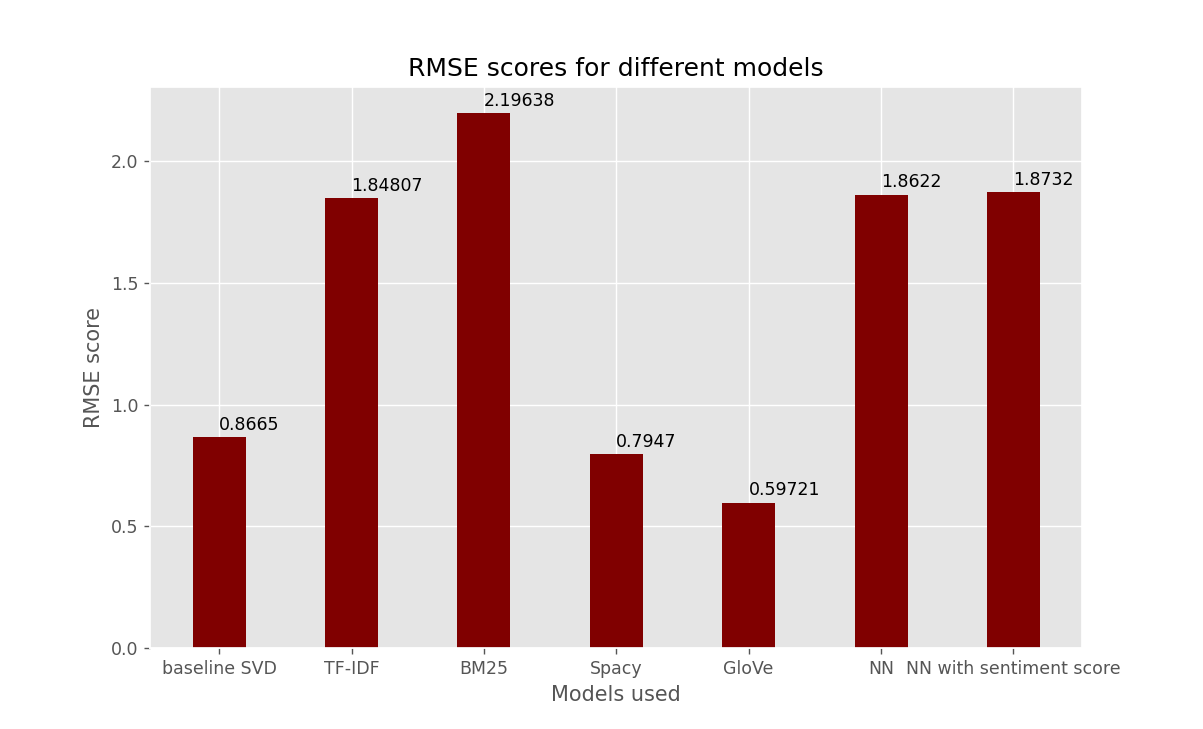

In [192]:
import matplotlib.pyplot as plt
  
fig = plt.figure(figsize = (7, 5))
 
# creating the bar plot
plt.bar(models, rmse_scores, color ='maroon',
        width = 0.4)
# adding text on bars
for i in range(len(rmse_scores)):
    plt.text(i,rmse_scores[i]+0.03,rmse_scores[i])

# adding labels
plt.xlabel("Models used")
plt.ylabel("RMSE score")
plt.title("RMSE scores for different models")
plt.show()

In [224]:
# sorting the data on Time taken
models_sorted = [x for _,x in sorted(zip(time_taken,models))]
time_taken.sort()

<IPython.core.display.Javascript object>


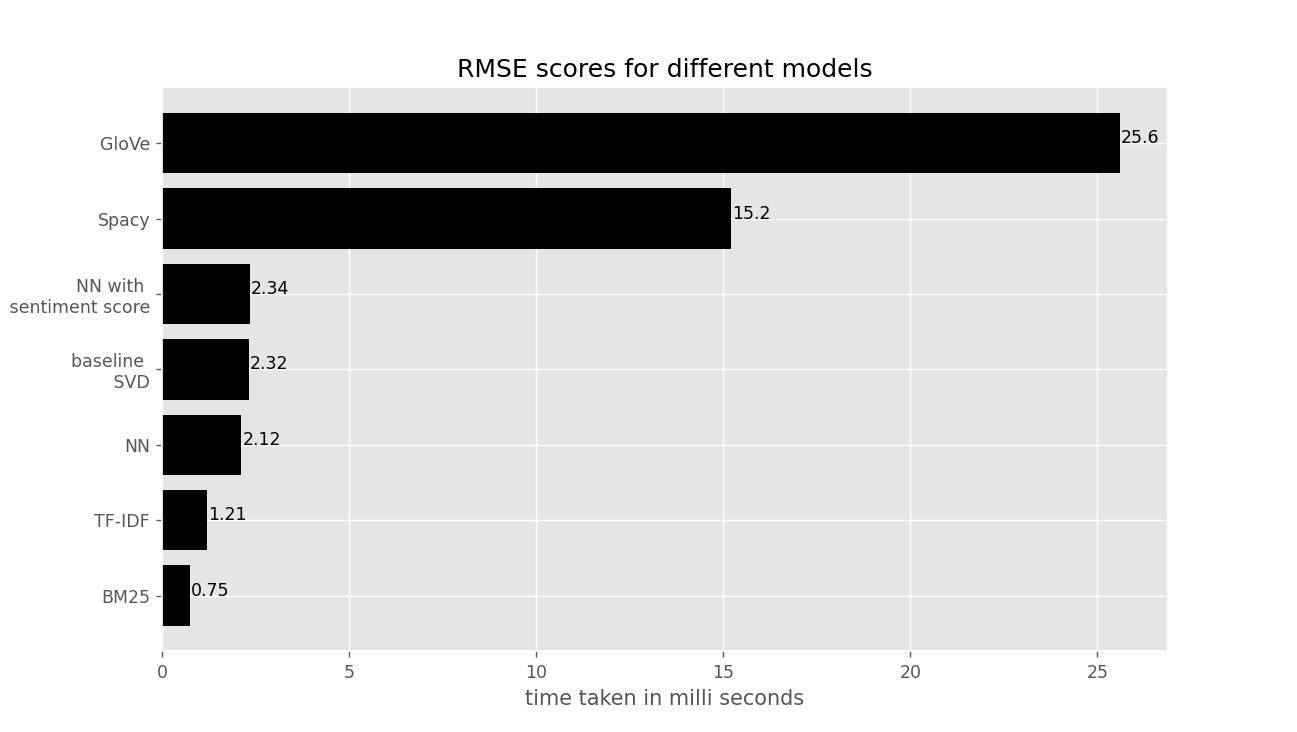

Text(0.5, 1.0, 'RMSE scores for different models')

In [226]:
fig, ax = plt.subplots()

# creating the bar plot
ax.barh(models_sorted, time_taken, color ='black')
for i in range(len(time_taken)):
    plt.text(time_taken[i]+0.03,i,time_taken[i])
# adding labels
       
ax.set_xlabel("time taken in milli seconds")
ax.set_title("RMSE scores for different models")
